# A11.1 - Modifying the Bandits Problem and the $ε$-Greedy Solver

* Jaan Tollander de Balsch, 452056

In [79]:
import time
import random
from functools import partial
from random import uniform

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

## Bernoulli-Uniform Bandit
The **reward** $r$ is a random number sampled from a probability distribution. The distributions are assumed to be known and independent, but the parameters unknown. For example, the reward for *Bernoulli-Uniform* bandit is
$$
r∼\operatorname{Bernoulli}(θ)⋅\operatorname{Uniform}(l,h)
$$
where $θ∈[0,1]$ and $l,h∈ℝ, l≤h$. The expected reward for action $a$ is
$$
\begin{aligned}
𝔼[r∣a] & = 𝔼[\operatorname{Bernoulli}(θ)]⋅𝔼[\operatorname{Uniform}(l,h)] \\ & =
θ ⋅ (l+h)/2.
\end{aligned}
$$

Other distributions could be used in similar way.

In [80]:
class BernoulliUniformBandit(object):
    def __init__(self, n, thetas, lows, highs):
        assert len(thetas) == len(lows) == len(highs) == n
        self.n = n
        self.thetas = thetas
        self.lows = lows
        self.highs = highs
        self.rewards = [t * (l + h) / 2 for (t, l, h) in
                        zip(thetas, lows, highs)]
        self.best_reward = max(self.rewards)

    def pull_arm(self, i):
        # Pull i-th arm and return reward
        if np.random.random() < self.thetas[i]:
            return uniform(self.lows[i], self.highs[i])
        else:
            return 0

## Epsilon-Greedy with Decreasing Epsilon
The Epsilon-Greedy should be modified such that initially it explores more in order to estimate the action values and as time increases and the evidence for action value estimates increase, the epsilon should decrease such that the best arm is exploited more often.

A naive formulation of epsilon $ε_t$ is to formulate it as a decreasing function $ε_{t+1}<ε_t$ of time $t$ starting from initial epsilon $ε_0$ decreasing towards zero as time tends towards infinity $t→∞$. For example,
$$
ε_t=\frac{ε_0}{t^{c}}
$$
where $c∈ℝ$ is a parameter that controls the rate of the decrease. For larger number of bandits the rate of decrease should be set lower. If $c=0$ the approach reduces to normal Epsilon-Greedy.

In [81]:
class Solver(object):
    def __init__(self, bandit):
        """
        bandit (Bandit): the target bandit to solve
        """
        assert isinstance(bandit, BernoulliUniformBandit)
        np.random.seed(int(time.time()))

        self.bandit = bandit

        self.counts = [0] * self.bandit.n
        self.actions = []  # History of actions (list of arms pulled)
        self.regret = 0.  # Cumulative regret
        self.regrets = [0.]  # History of cumulative regrets

    def update_regret(self, i):
        # i: index of selected arm
        self.regret += self.bandit.best_reward - self.bandit.rewards[i]
        self.regrets.append(self.regret)

    @property
    def estimated_rewards(self):
        raise NotImplementedError

    def run_one_step(self):
        """Return the arm index to take action on."""
        raise NotImplementedError

    def run(self, num_steps):
        assert self.bandit is not None
        for _ in range(num_steps):
            i = self.run_one_step()

            self.counts[i] += 1
            self.actions.append(i)
            self.update_regret(i)


class EpsilonGreedy(Solver):
    def __init__(self, bandit, epsilon0, rate=0.0, init_reward=1.0):
        """
        epsilon (float): the probability to explore
        init_theta (float): We optimistically set initial theta to be 1.0

        Parameters
        ----------
        rate
        """
        super(EpsilonGreedy, self).__init__(bandit)
        assert 0. <= epsilon0 <= 1.0
        self.epsilon0 = epsilon0
        self.rate = rate
        # Optimisistic initialisation
        self.estimates = [init_reward] * self.bandit.n
        self.name = f"Epsilon-Greedy (epsilon={epsilon0}, rate={rate})"
        self.time = 0

    @property
    def estimated_rewards(self):
        return self.estimates

    def run_one_step(self):
        self.time += 1
        epsilon = self.epsilon0 / self.time ** self.rate
        if np.random.random() < epsilon:
            # We are going to explore
            i = np.random.randint(0, self.bandit.n)  # Pick a random arm
        else:
            # We are going to exploit
            i = max(range(self.bandit.n), key=lambda x: self.estimates[x])

        reward = self.bandit.pull_arm(i)  # Pull arm i and get reward
        # Update estimate for arm i
        self.estimates[i] += 1. / (self.counts[i] + 1) * \
                             (reward - self.estimates[i])
        return i


def run_solver(solver, trials=20, iterations=1000):
    regret_history = []
    for trial in range(trials):
        solver.regret = 0
        solver.regrets = []
        solver.run(iterations)
        regret_history.append(solver.regret)
    print(solver.name, np.mean(regret_history), "+/-", np.std(regret_history))

## Results

In [82]:
bandit1 = BernoulliUniformBandit(
    3, 
    [0.15, 0.30, 0.60], 
    [2, 1.5, 1], 
    [2, 1.5, 1]
)

bandit2 = BernoulliUniformBandit(
    3, 
    [0.15, 0.30, 0.60], 
    [2, 1, 1], 
    [2, 3, 2]
)

bandit3 = BernoulliUniformBandit(
    3, 
    [0.10, 0.30, 0.60], 
    [10, 1, 1], 
    [20, 20, 5]
)

bandit4 = BernoulliUniformBandit(
    3, 
    [0.01, 0.30, 0.60], 
    [1000, 10, 10], 
    [2000, 50, 15]
)

bandit5 = BernoulliUniformBandit(
    3, 
    [1, 1, 1], 
    [1, 1, 1], 
    [100, 110, 120]
)

Epsilon-Greedy (epsilon=1.0, rate=0.5) 7.672499999999992 +/- 9.742759811778145
Expected rewards per arm: [0.3, 0.44999999999999996, 0.6]
Actions per arm:          [17.95, 15.25, 9966.8]



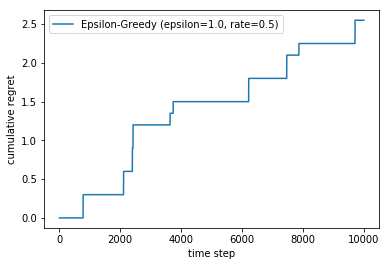

Epsilon-Greedy (epsilon=1.0, rate=0.5) 13.739999999999998 +/- 14.53486842045705
Expected rewards per arm: [0.3, 0.6, 0.8999999999999999]
Actions per arm:          [15.55, 14.7, 9969.75]



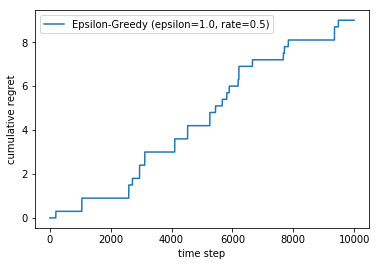

Epsilon-Greedy (epsilon=1.0, rate=0.5) 45.059999999999995 +/- 36.54716678485489
Expected rewards per arm: [1.5, 3.15, 1.7999999999999998]
Actions per arm:          [15.65, 9970.1, 14.25]



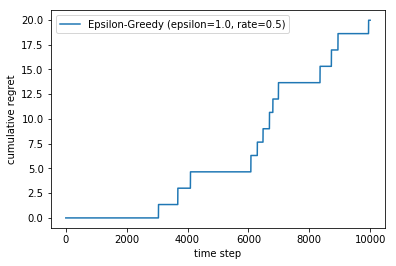

Epsilon-Greedy (epsilon=1.0, rate=0.5) 26241.975 +/- 29064.25187471501
Expected rewards per arm: [15.0, 9.0, 7.5]
Actions per arm:          [5629.9, 4355.85, 14.25]



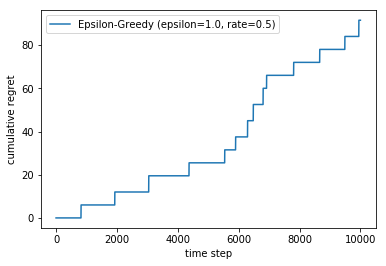

In [ ]:
%matplotlib inline
# Run experiment for each solver
for bandit in [bandit1, bandit2, bandit3, bandit4, bandit5]:
    # Instantiate solvers
    solvers = [
    #     EpsilonGreedy(bandit, 0.1, 0.0),
        EpsilonGreedy(bandit, 1.0, 1 / 2)
    ]
    for solver in solvers:
        num_trials = 20
        num_iterations = 10000
        run_solver(solver, num_trials, num_iterations)
        action_count = []
        for arm in range(bandit.n):
            action_count.append(solver.actions.count(arm) / num_trials)
        # Print number of times each arm was pulled
        print(f"Expected rewards per arm: {bandit.rewards}")
        print(f"Actions per arm:          {action_count}\n")  

    plt.figure()
    for solver in solvers:
        plt.plot(solver.regrets, label=solver.name)

    plt.legend()
    plt.xlabel('time step')
    plt.ylabel('cumulative regret')
    plt.show()
